In [ ]:
!nvcc --version
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu124
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
!pip install torchmetrics

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


Using device: cuda
Loading dataset...
Handling missing values...
Data cleaning done.
Number of Classes: 2
Class Distribution:
 Label
1    77750
0    70576
Name: count, dtype: int64
Initializing dataset...
Building vocabulary...
Vocabulary size: 713770
Creating graphs...
Total graphs created: 148326
Dataset initialization complete.


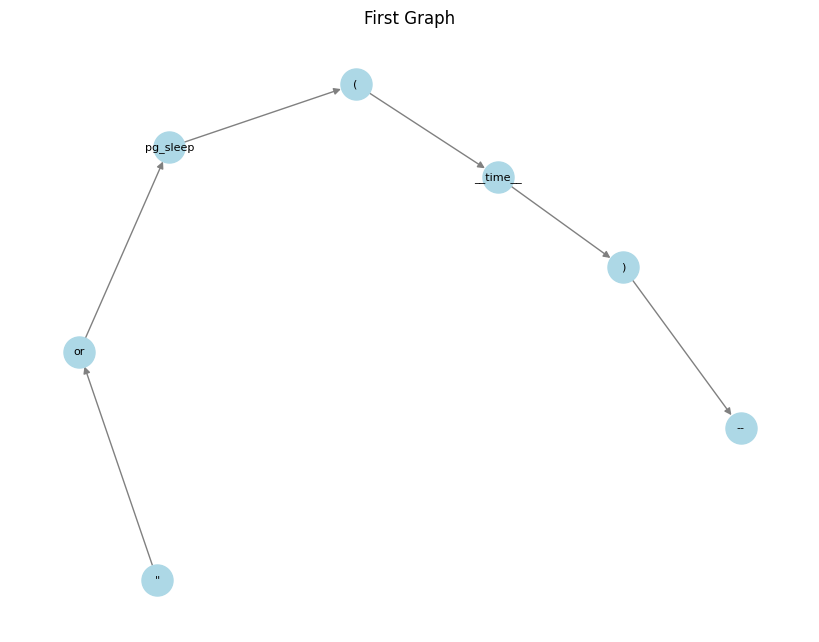

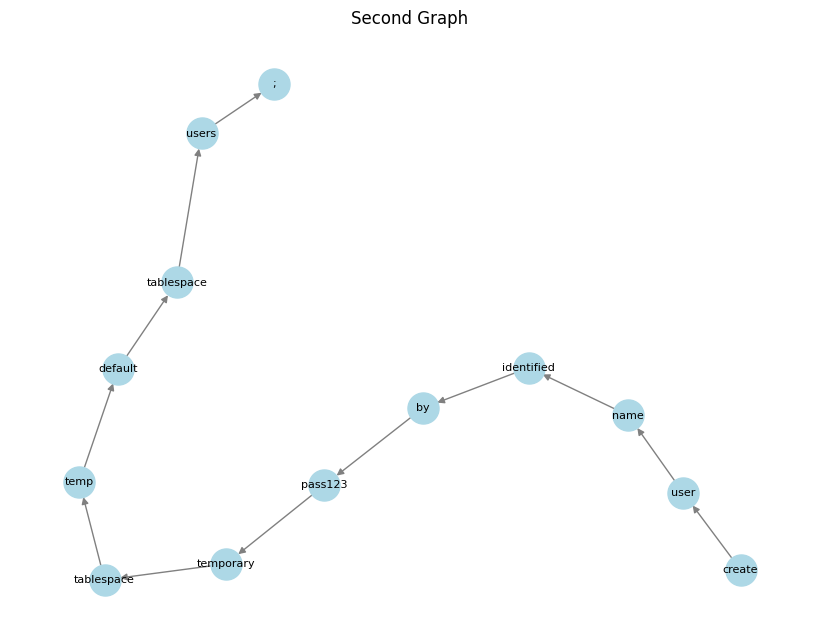

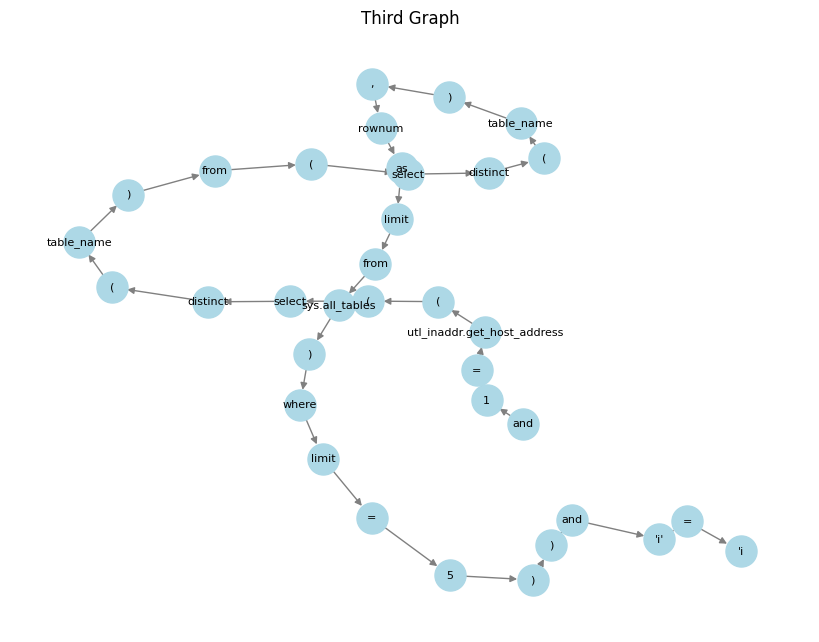

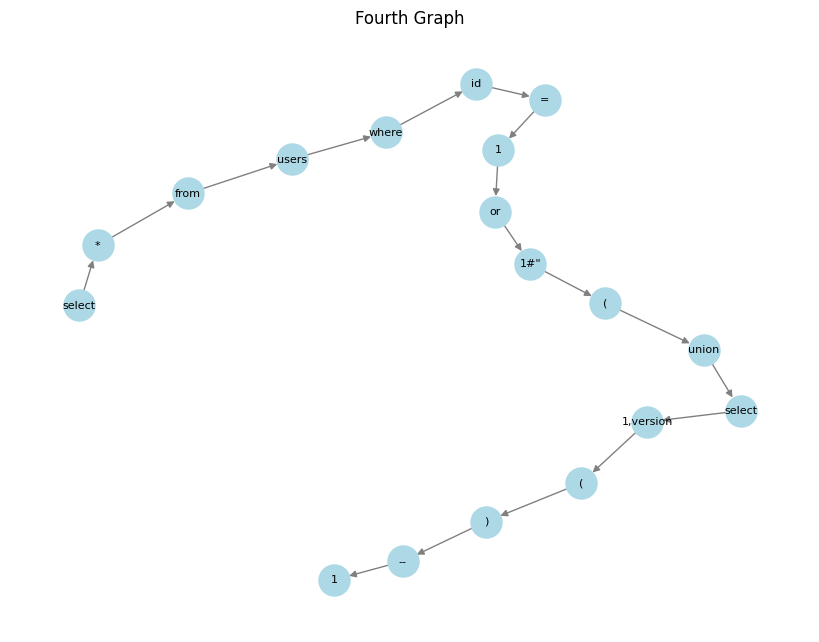

Splitting dataset...
Training samples: 118660, Test samples: 29666
Creating data loaders...
Data loaders ready.
Setting up training...
Initializing GCN model...
Model initialized.
Training setup complete.
Starting training...
Epoch 1/10 started...


Epoch 1/10:  17%|█▋        | 10204/59330 [06:53<33:12, 24.66it/s, loss=0.193]


KeyboardInterrupt: 

In [8]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from tqdm import tqdm
import networkx as nx

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/content/clean_sql_dataset.csv", on_bad_lines='skip', engine='python')



# Handle missing values
print("Handling missing values...")
df["Payload"] = df["Payload"].fillna("").astype(str)
df["Label"] = pd.to_numeric(df["Label"], errors="coerce").fillna(0).astype(int)
print("Data cleaning done.")

# Check dataset info
num_classes = df["Label"].nunique()
class_distribution = df["Label"].value_counts()

print(f"Number of Classes: {num_classes}")
print("Class Distribution:\n", class_distribution)

# Graph dataset class
class InjectionDataset:
    def __init__(self, df):
        print("Initializing dataset...")
        self.df = df
        self.vocab = {}
        self._build_vocab()
        self.graphs, self.labels = self._create_graphs()
        print("Dataset initialization complete.")

    def _build_vocab(self):
        print("Building vocabulary...")
        vocab = {}
        for payload in self.df["Payload"]:
            tokens = self._tokenize(payload)
            for token in tokens:
                if token not in vocab:
                    vocab[token] = len(vocab)
        self.vocab = vocab
        print(f"Vocabulary size: {len(self.vocab)}")

    def _tokenize(self, text):
        return text.lower().replace(";", " ; ").replace("(", " ( ").replace(")", " ) ").split()

    def _create_graphs(self):
        print("Creating graphs...")
        graphs = []
        labels = []

        for payload, label in zip(self.df["Payload"], self.df["Label"]):
            tokens = self._tokenize(payload)
            num_nodes = len(tokens)

            g = dgl.graph(([], []))
            g.add_nodes(num_nodes)

            token_ids = [self.vocab[t] for t in tokens]  # Zero-based indexing
            g.ndata["feat"] = torch.tensor(token_ids, dtype=torch.long).unsqueeze(1)

            # Create sequential edges
            src, dst = list(range(num_nodes - 1)), list(range(1, num_nodes))
            g.add_edges(src, dst)

            graphs.append(g)
            labels.append(label)

        print(f"Total graphs created: {len(graphs)}")
        return graphs, torch.tensor(labels, dtype=torch.long, device=device)





# Create dataset
dataset = InjectionDataset(df)
graphs = dataset.graphs
labels = dataset.labels

# Function to visualize a DGL graph with node labels
import networkx as nx

# Function to visualize a DGL graph with node labels
def plot_graph(g, vocab, title="Graph Visualization"):
    g = g.cpu()  # Move graph to CPU
    nx_g = g.to_networkx()

    pos = nx.spring_layout(nx_g)  # Positioning using spring layout

    # Get node labels from vocabulary
    node_labels = {i: list(vocab.keys())[list(vocab.values()).index(g.ndata["feat"][i].item())] for i in range(g.num_nodes())}

    plt.figure(figsize=(8, 6))
    nx.draw(nx_g, pos, with_labels=True, labels=node_labels, node_size=500, node_color="lightblue", edge_color="gray", font_size=8)
    plt.title(title)
    plt.show()

# Plot the first two graphs
plot_graph(graphs[0], dataset.vocab, title="First Graph")
plot_graph(graphs[1], dataset.vocab, title="Second Graph")
plot_graph(graphs[2], dataset.vocab, title="Third Graph")
plot_graph(graphs[4], dataset.vocab, title="Fourth Graph")




In [22]:
# Split dataset (fixed stratification)
print("Splitting dataset...")
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    graphs, labels.cpu(), test_size=0.2, random_state=42, stratify=labels.cpu()
)

print(f"Training samples: {len(train_graphs)}, Test samples: {len(test_graphs)}")

# Create data loaders
batch_size = 256
print("Creating data loaders...")
train_loader = GraphDataLoader(
    list(zip(train_graphs, train_labels)), batch_size=batch_size, shuffle=True
)
test_loader = GraphDataLoader(
    list(zip(test_graphs, test_labels)), batch_size=batch_size
)
print("Data loaders ready.")

# GCN Model with improvements
class GCNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64, num_classes=2):
        super().__init__()
        print("Initializing GCN model...")
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = GraphConv(embed_dim, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = GraphConv(hidden_dim, hidden_dim, allow_zero_in_degree=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, num_classes)
        self.dropout = nn.Dropout(0.5)
        print("Model initialized.")

    def forward(self, g):
        h = self.embed(g.ndata["feat"].squeeze(1).to(self.embed.weight.device))
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        with g.local_scope():
            g.ndata["h"] = h
            hg = dgl.mean_nodes(g, "h")
        hg = self.dropout(F.relu(self.fc1(hg)))
        return self.fc2(hg)

# Training setup
print("Setting up training...")
model = GCNClassifier(len(dataset.vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, eps=1e-8)
criterion = nn.CrossEntropyLoss()
print("Training setup complete.")

Splitting dataset...
Training samples: 118660, Test samples: 29666
Creating data loaders...
Data loaders ready.
Setting up training...
Initializing GCN model...
Model initialized.
Training setup complete.


Using device: cuda
Starting training...
Epoch 1/10 started...


Epoch 1/10: 100%|██████████| 464/464 [00:22<00:00, 20.67it/s, loss=0.257]


Epoch 1 | Loss: 0.2569 | Train Acc: 94.77% | Val Acc: 94.42%
Epoch 2/10 started...


Epoch 2/10: 100%|██████████| 464/464 [00:22<00:00, 20.86it/s, loss=0.139]


Epoch 2 | Loss: 0.1387 | Train Acc: 96.35% | Val Acc: 95.62%
Epoch 3/10 started...


Epoch 3/10: 100%|██████████| 464/464 [00:22<00:00, 21.09it/s, loss=0.111]


Epoch 3 | Loss: 0.1107 | Train Acc: 97.15% | Val Acc: 96.02%
Epoch 4/10 started...


Epoch 4/10: 100%|██████████| 464/464 [00:22<00:00, 20.38it/s, loss=0.0907]


Epoch 4 | Loss: 0.0907 | Train Acc: 97.91% | Val Acc: 96.10%
Epoch 5/10 started...


Epoch 5/10: 100%|██████████| 464/464 [00:21<00:00, 21.18it/s, loss=0.0756]


Epoch 5 | Loss: 0.0756 | Train Acc: 98.35% | Val Acc: 96.56%
Epoch 6/10 started...


Epoch 6/10: 100%|██████████| 464/464 [00:21<00:00, 21.42it/s, loss=0.0629]


Epoch 6 | Loss: 0.0629 | Train Acc: 98.70% | Val Acc: 96.51%
Epoch 7/10 started...


Epoch 7/10: 100%|██████████| 464/464 [00:21<00:00, 21.26it/s, loss=0.0521]


Epoch 7 | Loss: 0.0521 | Train Acc: 99.06% | Val Acc: 96.30%
Epoch 8/10 started...


Epoch 8/10: 100%|██████████| 464/464 [00:21<00:00, 21.33it/s, loss=0.0441]


Epoch 8 | Loss: 0.0441 | Train Acc: 99.23% | Val Acc: 96.45%
Epoch 9/10 started...


Epoch 9/10: 100%|██████████| 464/464 [00:22<00:00, 20.75it/s, loss=0.0369]


Epoch 9 | Loss: 0.0369 | Train Acc: 99.34% | Val Acc: 96.38%
Epoch 10/10 started...


Epoch 10/10: 100%|██████████| 464/464 [00:22<00:00, 20.33it/s, loss=0.0317]


Epoch 10 | Loss: 0.0317 | Train Acc: 99.44% | Val Acc: 96.24%
Saving trained model...
Model saved as 'gcn_model.pth'.
Evaluating model on test set...


Final Test Accuracy: 96.24%


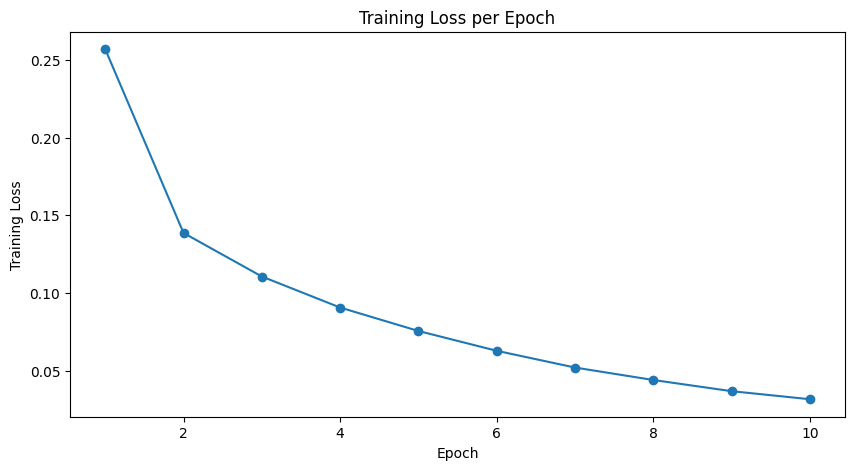

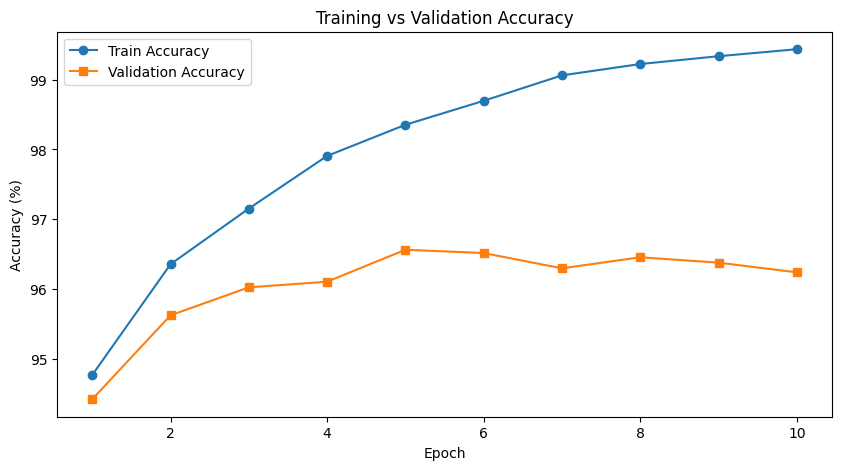

In [23]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from tqdm import tqdm
import networkx as nx
from torchmetrics.classification import Accuracy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Accuracy Metric
accuracy_metric = Accuracy(task="multiclass", num_classes=2).to(device)

# Function to compute accuracy with tqdm progress bar
def compute_accuracy(model, loader):
    model.eval()
    accuracy_metric.reset()

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Evaluating", leave=False)
        for batched_graphs, batched_labels in progress_bar:
            batched_graphs = batched_graphs.to(device)
            batched_labels = batched_labels.to(device).long()

            logits = model(batched_graphs)
            predicted = torch.argmax(logits, dim=1)

            accuracy_metric.update(predicted, batched_labels)

    return accuracy_metric.compute().item() * 100  # Convert to percentage


# Training loop with tqdm
num_epochs = 10
train_losses = []
train_accs = []
val_accs = []

print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} started...")
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for batched_graphs, batched_labels in progress_bar:
        batched_graphs = batched_graphs.to(device)
        batched_labels = batched_labels.to(device).long()

        logits = model(batched_graphs)
        loss = criterion(logits, batched_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / len(train_loader))

    train_loss = total_loss / len(train_loader)
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, test_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# Save trained model
print("Saving trained model...")
torch.save(model.state_dict(), "/content/gcn_model.pth")
print("Model saved as 'gcn_model.pth'.")

# Final evaluation
print("Evaluating model on test set...")
test_accuracy = compute_accuracy(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# Plot training loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.show()

# Plot accuracy trends
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), val_accs, label="Validation Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


In [29]:
import torch
import dgl
from torch.utils.data import DataLoader
from dgl.dataloading import GraphDataLoader

# Load trained model
model = GCNClassifier(len(dataset.vocab)).to(device)
model.load_state_dict(torch.load("gcn_model.pth"))
model.eval()
print("Model loaded successfully.")

# 🔹 Benign GET/POST Parameters
benign_params = [
    "username=john&password=securePass123",
    "email=user@example.com&age=25&city=NewYork",
    "product_id=1234&quantity=2",
    "comment=This is a great product!&rating=5",
    "name=Alice&message=Hello, how are you?",
]

# 🔥 SQL Injection Payloads in GET/POST Parameters
sqli_params = [
    "username=admin' --&password=anything",
    "email=hacker@example.com&password=' OR '1'='1",
    "query=' UNION SELECT username, password FROM users --",
    "amount=1000; DROP TABLE accounts; --",
    "user_id=' OR EXISTS(SELECT * FROM users) --",
]

# Function to convert GET/POST parameters into graphs
def create_graph_from_params(params, vocab):
    tokens = params.lower().replace(";", " ; ").replace("(", " ( ").replace(")", " ) ").split()
    num_nodes = len(tokens)

    g = dgl.graph(([], []))
    g.add_nodes(num_nodes)

    token_ids = [vocab.get(t, 0) for t in tokens]  # Use 0 if token not found in vocab
    g.ndata["feat"] = torch.tensor(token_ids, dtype=torch.long).unsqueeze(1)

    src, dst = list(range(num_nodes - 1)), list(range(1, num_nodes))
    g.add_edges(src, dst)

    return g

# Convert parameters into graphs
benign_graphs = [create_graph_from_params(p, dataset.vocab) for p in benign_params]
sqli_graphs = [create_graph_from_params(p, dataset.vocab) for p in sqli_params]

# Create DataLoaders
benign_loader = GraphDataLoader(list(zip(benign_graphs, [0]*len(benign_graphs))), batch_size=1, shuffle=False)
sqli_loader = GraphDataLoader(list(zip(sqli_graphs, [1]*len(sqli_graphs))), batch_size=1, shuffle=False)

# Function to predict SQLi
def predict_sqli(model, loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batched_graphs, _ in loader:
            batched_graphs = batched_graphs.to(device)
            logits = model(batched_graphs)
            _, predicted = torch.max(logits, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions

# Run prediction
benign_results = predict_sqli(model, benign_loader)
sqli_results = predict_sqli(model, sqli_loader)

# Display results
print("\n--- ✅ Legitimate Parameter Predictions ---")
for param, label in zip(benign_params, benign_results):
    print(f"Params: {param} -> Predicted Label: {label}")

print("\n--- 🚨 SQL Injection Parameter Predictions ---")
for param, label in zip(sqli_params, sqli_results):
    print(f"Params: {param} -> Predicted Label: {label}")


Initializing GCN model...
Model initialized.


<ipython-input-29-bc037fa2477e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gcn_model.pth"))


Model loaded successfully.

--- ✅ Legitimate Parameter Predictions ---
Params: username=john&password=securePass123 -> Predicted Label: 0
Params: email=user@example.com&age=25&city=NewYork -> Predicted Label: 0
Params: product_id=1234&quantity=2 -> Predicted Label: 0
Params: comment=This is a great product!&rating=5 -> Predicted Label: 0
Params: name=Alice&message=Hello, how are you? -> Predicted Label: 1

--- 🚨 SQL Injection Parameter Predictions ---
Params: username=admin' --&password=anything -> Predicted Label: 0
Params: email=hacker@example.com&password=' OR '1'='1 -> Predicted Label: 1
Params: query=' UNION SELECT username, password FROM users -- -> Predicted Label: 1
Params: amount=1000; DROP TABLE accounts; -- -> Predicted Label: 1
Params: user_id=' OR EXISTS(SELECT * FROM users) -- -> Predicted Label: 1
